# Tuning experiments for the Movielens dataset

Feel free to re-run this and change hyperparameters as you see fit.

This notebook should also be a good place to load the data only once and then train multiple times, generate charts, etc.


In [61]:
from data_loader import load_data, train_test_split, MovielensDataset
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
import argparse
import yaml
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error

from gmf import GMF
from ncf_mlp import NCF_MLP
from neural_mf import NEURAL_MF

from train import train_gmf, train_joint_nerual_mf, train_mlp, train_neural_mf, train_loop, test_loop

from matplotlib import pyplot as plt

In [13]:
# Starting hyperparameters
learning_rate = 0.05
weight_decay = 0.0000001
epochs = 5
batch_size = 1024
latent_dims = 16
alpha: 0.5
loss = nn.MSELoss()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Load the data
dataset = '100k'
data, num_users, num_items = load_data(dataset, rescale_data=True)
train, test = train_test_split(data)

In [16]:
train = MovielensDataset(users=train['user_id'], movies=train['movie_id'], ratings = train['rating'])
test = MovielensDataset(users=test['user_id'], movies=test['movie_id'], ratings = test['rating'])

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers= 4)

## Tune Hyperparameters for Models

In [49]:
def tune_lr(model_type='gmf'):
    """Tune Learning Rate for a model type"""
    learning_rates = np.array([0.001, 0.01, 0.05, 0.07, 0.1, 0.2])
    rmse_history = []
    test_rmse_history = []
    best_model = None
    best_lr = 0.01
    best_RMSE = np.inf
    for lr in learning_rates:
        if model_type == 'gmf':
            print('TRAINING GMF')
            train_model = train_gmf
        elif model_type == 'mlp':
            print('TRAINING MLP')
            train_model = train_mlp
        else:
            print('TRAINING NMF')
            train_model = train_nmf
        model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs, latent_dims,
                            lr, # Param being tuned
                            'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)

        rmse = test_loop(train_dataloader, model, loss, device, rescale_data=True)
        rmse_history.append(rmse)
        test_rmse = test_loop(test_dataloader, model, loss, device, rescale_data=True)
        test_rmse_history.append(test_rmse)

        # Select the best model based on TRAIN RMSE, not TEST RMSE
        if rmse < best_RMSE:
            best_lr = lr
            best_RMSE = rmse
            best_model = model

    rmse_history = np.array(rmse_history)
    test_rmse_history = np.array(test_rmse_history)
    test_rmse = test_loop(test_dataloader, best_model, loss, device, rescale_data=True)

    print()
    print('Finished tuning model', model_type)
    print('Best Learning Rate:', best_lr)
    print('Best Train RMSE:', best_RMSE)
    print('Best Test RMSE:', test_rmse)

    curve_data = {
        'Train RMSE': rmse_history,
        'Test RMSE': test_rmse_history,
    }

    return (best_lr, best_model, learning_rates, curve_data)


In [69]:
def tune_dims(model_type='gmf'):
    """Tune Embedding Dimensions for a model type"""
    dims = [8, 16, 32, 64, 128, 256]
    rmse_history = []
    test_rmse_history = []
    best_model = None
    best_dim = 0.01
    best_RMSE = np.inf
    for dim in dims:
        if model_type == 'gmf':
            print('TRAINING GMF')
            train_model = train_gmf
        elif model_type == 'mlp':
            print('TRAINING MLP')
            train_model = train_mlp
        else:
            print('TRAINING NMF')
            train_model = train_nmf
        model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs,
                            dim, # Param being tuned 
                            learning_rate, 'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)

        rmse = test_loop(train_dataloader, model, loss, device, rescale_data=True)
        rmse_history.append(rmse)
        test_rmse = test_loop(test_dataloader, model, loss, device, rescale_data=True)
        test_rmse_history.append(test_rmse)

        # Select the best model based on TRAIN RMSE, not TEST RMSE
        if rmse < best_RMSE:
            best_dim = dim
            best_RMSE = rmse
            best_model = model

    rmse_history = np.array(rmse_history)
    test_rmse_history = np.array(test_rmse_history)
    test_rmse = test_loop(test_dataloader, best_model, loss, device, rescale_data=True)

    print()
    print('Finished tuning model', model_type)
    print('Best Embedding Dim:', best_dim)
    print('Best Train RMSE:', best_RMSE)
    print('Best Test RMSE:', test_rmse)

    curve_data = {
        'Train RMSE': rmse_history,
        'Test RMSE': test_rmse_history,
    }

    return (best_dim, best_model, dims, curve_data)


In [65]:
gmf_lr, gmf_model, gmf_lr_history, gmf_lr_curves = tune_lr('gmf')

TRAINING GMF
Epoch 1
------------------------
loss: 0.807671  [ 1024/79619]
Test MSE 13.32705864765462
Test RMSE 3.650624418870643
Epoch 2
------------------------
loss: 0.539426  [ 1024/79619]
Test MSE 9.909443931627639
Test RMSE 3.147926926030469
Epoch 3
------------------------
loss: 0.403459  [ 1024/79619]
Test MSE 7.719142836304836
Test RMSE 2.7783345436258817
Epoch 4
------------------------
loss: 0.301767  [ 1024/79619]
Test MSE 6.117054933843659
Test RMSE 2.4732680675259724
Epoch 5
------------------------
loss: 0.236920  [ 1024/79619]
Test MSE 4.8844680947366435
Test RMSE 2.2100832777831343
Test MSE 4.873762201438492
Test RMSE 2.207659892609931
Test MSE 4.8844680947366435
Test RMSE 2.2100832777831343
TRAINING GMF
Epoch 1
------------------------
loss: 0.665603  [ 1024/79619]
Test MSE 1.2906456219522249
Test RMSE 1.136065852823781
Epoch 2
------------------------
loss: 0.049368  [ 1024/79619]
Test MSE 1.2942890904148079
Test RMSE 1.1376682690550914
Epoch 3
---------------------

In [66]:
def plot_learning_curve(param_history, curves, title='Training Curve'):
    """Plot learning curves for a given model's tuning history

    curves -- a dictionary from a curve label to its historical data. The length of the curve history should be equal
              to the length of param_history
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    curve_labels = curves.keys()
    for curve_label in curve_labels:
        curve_data = curves[curve_label]
        ax.plot(param_history, curve_data, label=curve_label)

    fig.suptitle(title)
    fig.legend()
    fig.show()
    

/tmp/ipykernel_544403/1503343490.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


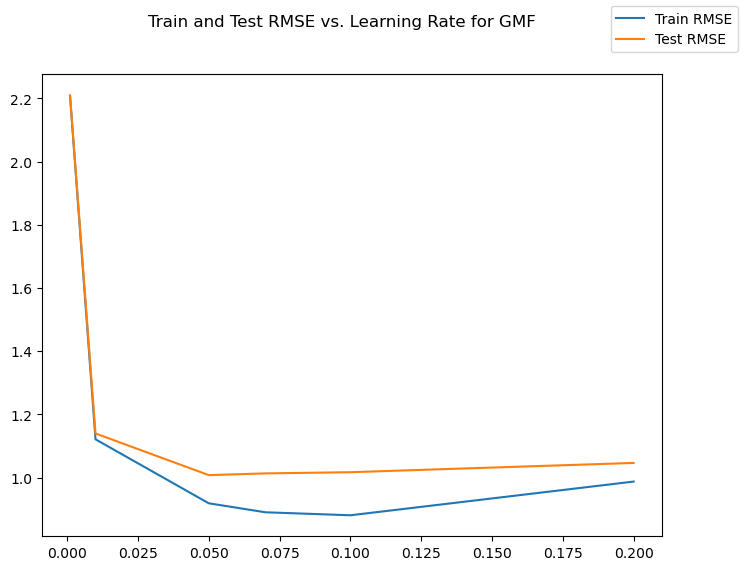

In [70]:
plot_learning_curve(gmf_lr_history, gmf_lr_curves, "Train and Test RMSE vs. Learning Rate for GMF")

In [71]:
gmf_dim, gmf_model, gmf_dim_history, gmf_dim_curves = tune_dims('gmf')

TRAINING GMF
Epoch 1
------------------------
loss: 1.033161  [ 1024/79619]
Test MSE 1.2996242574221841
Test RMSE 1.1400106391706106
Epoch 2
------------------------
loss: 0.049957  [ 1024/79619]
Test MSE 1.2958563473922182
Test RMSE 1.138356862935441
Epoch 3
------------------------
loss: 0.053752  [ 1024/79619]
Test MSE 1.29418570899446
Test RMSE 1.1376228324864353
Epoch 4
------------------------
loss: 0.049823  [ 1024/79619]
Test MSE 1.2529334865058757
Test RMSE 1.1193451150140763
Epoch 5
------------------------
loss: 0.046923  [ 1024/79619]
Test MSE 1.0420537258584894
Test RMSE 1.0208103280524201
Test MSE 0.9628209806145702
Test RMSE 0.9812344167499274
Test MSE 1.0420537258584897
Test RMSE 1.0208103280524201
TRAINING GMF
Epoch 1
------------------------
loss: 1.176611  [ 1024/79619]
Test MSE 1.299772649068734
Test RMSE 1.1400757207610088
Epoch 2
------------------------
loss: 0.050907  [ 1024/79619]
Test MSE 1.2982493966363853
Test RMSE 1.1394074761192263
Epoch 3
----------------

/tmp/ipykernel_544403/1503343490.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


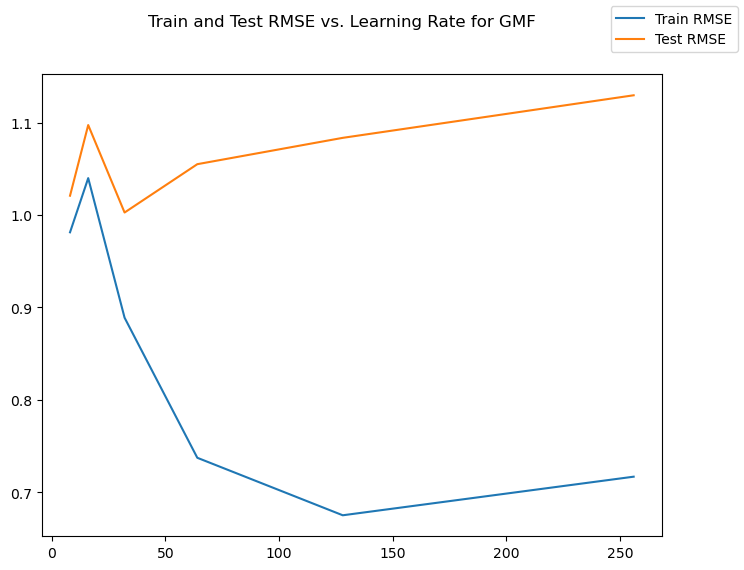

In [72]:
plot_learning_curve(gmf_dim_history, gmf_dim_curves, "Train and Test RMSE vs. Learning Rate for GMF")